# Lamellipodia Analysis

## Import packages

Required Python packages are imported here.

In [7]:
import sys
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Circle-Fit
import circle_fit as cf

# Import shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

sys.path.append('C:/Users/sean2/Documents/Biology/Dissertation/MCSTracker/src/')

import mesh
import tracking

## Process Cellpose segmentations

### Define functions (from LEC Analysis code)

In [3]:
def read_in_images_unchanged(path_to_images):
    '''
    A function to read in images from a specified folder and store them in an array.
    
    Parameters
    ---------- 
    path_to_images: string
    Path to the folder containing the images, e.g. 'C:/Users/this_user/data/image_folder/'
    
    Output
    ------
    An array containing the image arrays.
    '''
    
    #List the names of the files in the specified folder numerically.
    list_of_file_paths = list_file_paths_in_folder_numerically(path_to_images)
    
    #Make an empty array to store the images.
    images=[]
    
    #Read in the input files and append them to the array. 
    #cv2.IMREAD_UNCHANGED ensures that the properties of the images (e.g. bit depth and number of channels) are not changed.        
    for frame_index in range(len(list_of_file_paths)):
        image = cv2.imread(list_of_file_paths[frame_index], cv2.IMREAD_UNCHANGED)
        image_copy = image.copy()
        images.append(image_copy)
    
    #Return the array of images.   
    return images

def list_file_paths_in_folder_numerically(path_to_folder):
    '''
    Numerically list file paths in the specified folder.
    
    Parameters
    ---------- 
    path_to_folder: string 
    Path to the folder containing the images, e.g. 'C:/Users/this_user/data/folder/'
    
    Output
    ------
    A 1D numpy array of numerically sorted file paths.
    '''
    
    #Make an empty array to store the file names.
    file_paths= []
        
    #Append the path to each file in the specified folder to the list of file names.
    #Loop through the names of all of the items in the folder.
    for files in os.listdir(path_to_folder):
        #If a given item is a file,
        if os.path.isfile(os.path.join(path_to_folder, files)):
            #Get its path,
            file_path = os.path.join(path_to_folder, files)
            #and append the path to the list.
            file_paths.append(file_path)
                
    #Sort the file paths numerically.
    sorted_file_paths = sort_filenames_numerically(file_paths)
    
    #Return the sorted file paths.
    return sorted_file_paths

def sort_filenames_numerically(list_of_file_names):
    '''
    Sort a list of file names numerically.
    '''      
    numerically_sorted_filenames=sorted(list_of_file_names, key=numerical_sorting_function)       
    return numerically_sorted_filenames
      

def numerical_sorting_function(filename):
    '''
    A helper function which sorts file names numerically. 
        
    '''
    nondigits = re.compile("\D")
    return int(nondigits.sub("", filename)) 
    


### Code usage

In [4]:
# Define the path to the tracked segmentations   
path_to_segmentations = 'C:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence/'
# Read in the tracked segmentations
tracked_segmentations = read_in_images_unchanged(path_to_segmentations)

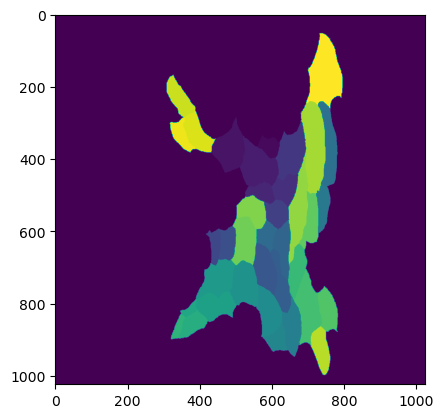

In [9]:
# Plot the first frame from tracked segmentations

#print(np.array(tracked_segmentations).shape)
first_frame = tracked_segmentations[0]
#print(first_frame.shape)
plt.figure()
plt.imshow(first_frame)
#plt.savefig('first_frame_values.png', dpi=1200);
plt.show()

## Finding cell edges and vertices

### Test with a specific cell

Draft code created to obtain edges and vertices for a single cell.

* Find and mask a specific cell in the first frame
* Obtain mesh sequence for first frame
* Extract nodes from mesh
* Extract contours from mask
* Adjust node positions to match pixel position
* Define edges of the cell

the cell ids present in the image are
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


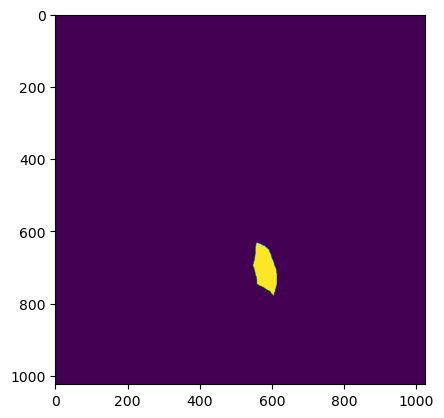

In [10]:
# Create a mask for a specific cell, e.g. cell with pixel value 10

print('the cell ids present in the image are')
print(np.unique(first_frame))

mask = first_frame == 10
# or
#other_image = mask*10
plt.imshow(mask)
#plt.savefig('cell_mask_values.png', dpi=1200);
plt.show()

In [11]:
# Create mesh sequence of cells in each frame
mesh_sequence = mesh.read_sequence_from_data(path_to_segmentations)

# Extract mesh from first frame
first_mesh = mesh_sequence[0]

readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_0_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_1_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_2_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_3_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_4_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_5_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_6_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_7_master.tif


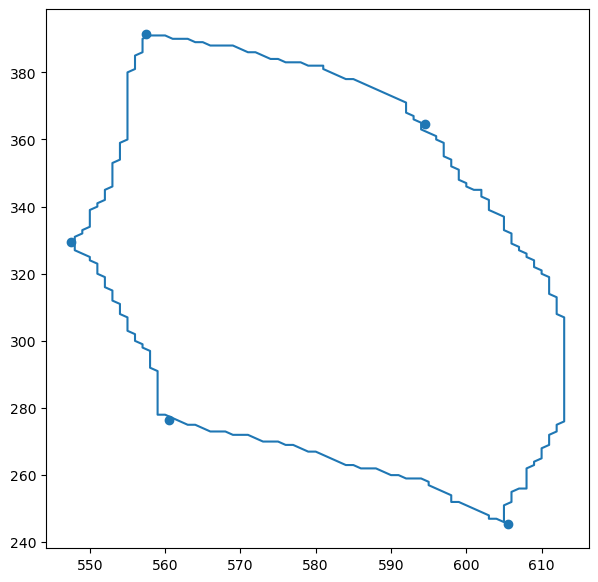

In [12]:
# Identify nodes of test cell
cell10_nodes = first_mesh.get_element_with_frame_id(10).nodes
# Extract positions of nodes
cell10_nodesPos = []
for node in cell10_nodes:
    cell10_nodesPos.append(node.position)
cell10_nodesPos = np.array(cell10_nodesPos)

# Get array of contour points around cell
contours = np.array(mesh.get_contour_list(mask)[0][0][0])
# Add first point to the end
contours = np.append(contours, [contours[0]], axis=0)
x = contours[:, 0, 0]
y = 1024 - contours[:, 0, 1]
# Create new contour array where the y axis is transformed
new_contours = np.column_stack((x,y))

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(x,y)
ax.scatter(cell10_nodesPos[:, 0], cell10_nodesPos[:, 1])
plt.show()

Previous node positions:
[[557.5 391.5]
 [547.5 329.5]
 [560.5 276.5]
 [605.5 245.5]
 [594.5 364.5]]
New node positions:
[[558 391]
 [548 329]
 [561 277]
 [605 246]
 [594 365]]


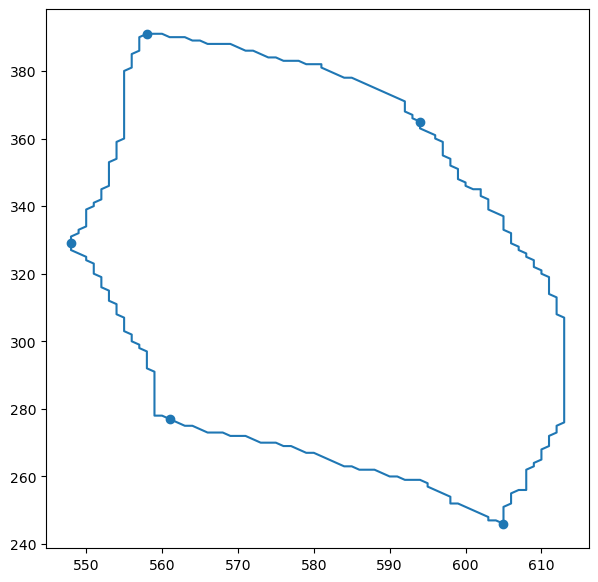

In [13]:
# Euclidean distance between two points
def distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

# Adjust node positions to match closest pixel positions
new_node_positions = []
for i, node_pos in enumerate(cell10_nodesPos):
    # find the closest pixel
    closest_distance = 1.5
    for pixel_loc in new_contours:
        # find distance to node_position
        this_distance = distance(pixel_loc, node_pos)
        if this_distance < closest_distance:
            closest_pixel = pixel_loc
    new_node_positions.append(closest_pixel)
new_node_positions = np.array(new_node_positions)
print('Previous node positions:')
print(cell10_nodesPos)
print('New node positions:')
print(new_node_positions)

fig, ax = plt.subplots(figsize=(7,7))
ax.plot(x,y)
ax.scatter(new_node_positions[:, 0], new_node_positions[:, 1]);

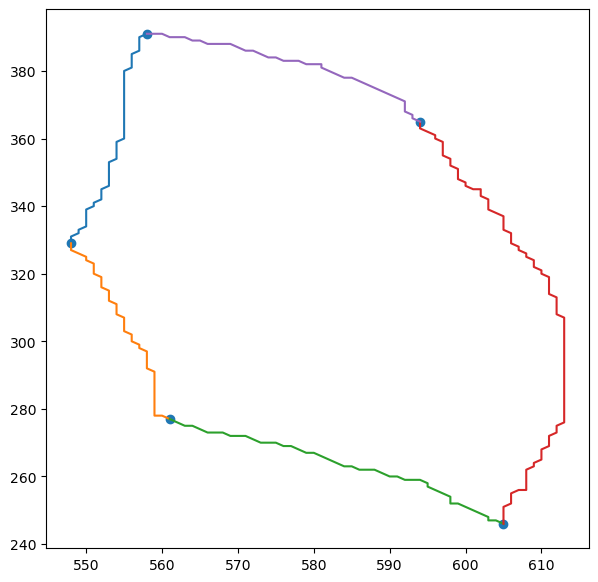

In [14]:
# Define edges of cell
n = len(new_node_positions)
edges = []

for i in range(n):
    node1 = new_node_positions[i]
    if (i+1 > n-1):
        node2 = new_node_positions[0]
    else:
        node2 = new_node_positions[i+1]
    
    index1 = np.where((new_contours == node1).all(axis=1))[0]
    index2 = np.where((new_contours == node2).all(axis=1))[0]
    
    # If two indices are found, choose index with shortest distance to next index
    if (len(index1) > 1):
        if (np.abs(index1[0]-index2) < np.abs(index1[1]-index2)):
            index1 = index1[0]
        else:
            index1 = index1[1]
    else:
        index1 = index1[0]   # Convert from array to scalar object
    if (len(index2) > 1):
        if (np.abs(index2[0]-index1) < np.abs(index2[1]-index1)):
            index2 = index2[0]
        else:
            index2 = index2[1]
    else:
        index2 = index2[0]
    
    edges.append(new_contours[int(index1):int(index2)+1])

# Extract x and y elements of edges
edges_x = {}
edges_y = {}
for i, edge in enumerate(edges):
    edges_x[i] = [pixel[0] for pixel in edge]
    edges_y[i] = [pixel[1] for pixel in edge]
# Plot edges
fig, ax = plt.subplots(figsize=(7,7))
for i in range(len(edges)):
    ax.plot(edges_x[i],edges_y[i])
ax.scatter(new_node_positions[:, 0], new_node_positions[:, 1]);

### Define functions

Generalise for all cells by defining functions from tests with single cell.

In [15]:
def get_node_positions(frame_mesh, frame_id=None):
    all_node_positions = {}
    id_dict = frame_mesh.frame_id_dictionary
    for i in id_dict.keys():
        node_positions = []
        nodes = frame_mesh.get_element_with_frame_id(i).nodes
        for node in nodes:
            node_positions.append(node.position)
        all_node_positions[i] = node_positions
    if frame_id:
        if frame_id in all_node_positions:
            return all_node_positions[frame_id]
        else:
            return None
    else:
        return all_node_positions

def get_contour_points(frame_image, frame_id=None):
    contours = {}
    contour_list = mesh.get_contour_list(frame_image)
    frame_ids = contour_list[1]
    for i,fid in enumerate(frame_ids):
        x = contour_list[0][i][0][:, 0, 0]
        y = 1024 - contour_list[0][i][0][:, 0, 1]
        x = np.append(x, [x[0]], axis=0)
        y = np.append(y, [y[0]], axis=0)
        contours[fid] = np.column_stack((x, y))
    if frame_id:
        return contours[frame_id]
    else:
        return contours

# Euclidean distance between two points
def get_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

def adjust_nodes(nodes, contour_points):
    all_new_node_positions = {}
    closest_distance = 1.4
    for frame_id in nodes:
        new_node_positions = []
        for node in nodes[frame_id]:
            # find the closest pixel
            for pixel in contour_points[frame_id]:
                # find distance to node_position
                this_distance = get_distance(pixel, node)
                if this_distance < closest_distance:
                    closest_pixel = pixel
            new_node_positions.append(closest_pixel)
        all_new_node_positions[frame_id] = new_node_positions
    return all_new_node_positions

def get_edges(adjusted_nodes, contour_points):
    all_edges = {}
    for frame_id in adjusted_nodes:
        nodes = adjusted_nodes[frame_id]
        contours = contour_points[frame_id]
        n = len(nodes)
        edges = []
        for i in range(n):
            node1 = nodes[i]
            if (i+1) > (n-1):
                node2 = nodes[0]
            else:
                node2 = nodes[i+1]

            index1 = np.where((contours == node1).all(axis=1))[0]
            index2 = np.where((contours == node2).all(axis=1))[0]
            
            # If two indices are found, choose index with shortest distance to next index
            if (len(index1) > 1):
                if (np.abs(index1[0]-index2) < np.abs(index1[1]-index2)):
                    index1 = index1[0]
                else:
                    index1 = index1[1]
            else:
                index1 = index1[0]   # Convert from array to scalar object
            
            if (len(index2) > 1):
                if (np.abs(index2[0]-index1) < np.abs(index2[1]-index1)):
                    index2 = index2[0]
                else:
                    index2 = index2[1]
            else:
                index2 = index2[0]
            
            # Check if edge crosses index boundary of contour points 
            if index1 > index2:
                edge = np.concatenate((contours[int(index1):-1], contours[0:int(index2)]), axis=0)
                edges.append(edge)
            else:
                edges.append(contours[int(index1):int(index2)+1])
            
        all_edges[frame_id] = edges
    return all_edges

## Edge curvature analysis

Possible methods:
* Find radius (R) and curvature (1/R) for each edge from circle fitting
* Look at edge and calculate arc length - how does it compare to straight line as circle will be longer than line
* Find quadratic and define curvature from it - polynomical fit and get second derivative at each point to assess curvature

### Circle fitting

Use a circle fitting library for Python.

The library Circle Fit implements a collection of different circle fitting algorithms, such as least squares or algebraic circle fits.

#### Test with a specific cell

Draft code created to test circle fitting method for a single cell.

* Test with algebraic Taubin SVD circle fit
* Use initial guess from Taubin fit to test with geometric Levenberg-Marquardt circle fit

Curvatures: [0.0037999  0.00534316 0.00952582 0.00754547 0.01899927]


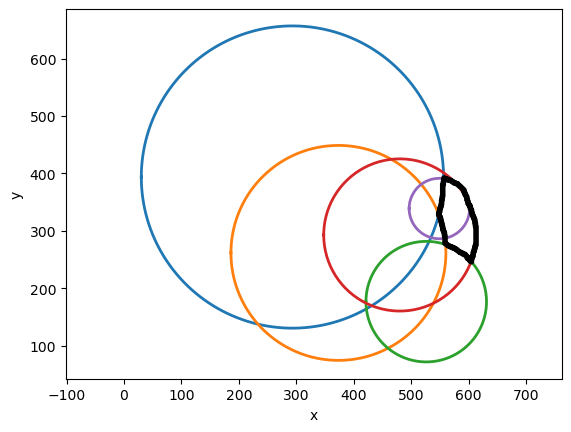

In [16]:
# Obtain circle fitting from edges of single cell
nedges = len(edges)

xc1 = np.zeros(nedges)
yc1 = np.zeros(nedges)
r1 = np.zeros(nedges)
sigma1 = np.zeros(nedges)

for i in range(nedges):
    xc1[i], yc1[i], r1[i], sigma1[i] = cf.taubinSVD(edges[i])
print('Curvatures:', 1 / r1)
    
# Plot circle fit for each edge
fig1 = plt.figure(facecolor='white')
plt.axis('equal')

theta_fit = np.linspace(-np.pi, np.pi, 180)

x_fit = np.zeros(nedges, dtype=object)
y_fit = np.zeros(nedges, dtype=object)
for i in range(nedges):
    x_fit[i] = xc1[i] + r1[i] * np.cos(theta_fit)
    y_fit[i] = yc1[i] + r1[i] * np.sin(theta_fit)
    plt.plot(x_fit[i], y_fit[i], lw=2)

plt.xlabel('x')
plt.ylabel('y')
# plot data
plt.plot(x, y, c='black', linewidth=4)
plt.show()

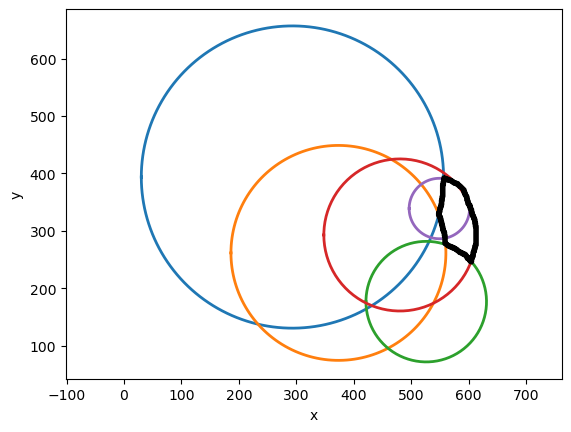

In [17]:
xclm = np.zeros(nedges)
yclm = np.zeros(nedges)
rlm = np.zeros(nedges)
sigmalm = np.zeros(nedges)

for i in range(nedges):
    xclm[i], yclm[i], rlm[i], sigmalm[i] = cf.lm(edges[i], np.array([xc1[i], yc1[i], r1[i]]))
    
# Plot circle fit for each edge
fig1 = plt.figure(facecolor='white')
plt.axis('equal')

theta_fit = np.linspace(-np.pi, np.pi, 180)

x_fit = np.zeros(nedges, dtype=object)
y_fit = np.zeros(nedges, dtype=object)
for i in range(nedges):
    x_fit[i] = xclm[i] + rlm[i] * np.cos(theta_fit)
    y_fit[i] = yclm[i] + rlm[i] * np.sin(theta_fit)
    plt.plot(x_fit[i], y_fit[i], lw=2)

plt.xlabel('x')
plt.ylabel('y')
# plot data
plt.plot(x, y, c='black', linewidth=4)
plt.show()

#### Define functions

Define functions to perform circle fitting and obtain curvatures from given edges

In [18]:
def get_circlefit(edges):
    xcs = {}
    ycs = {}
    rs = {}
    sigmas = {}
    for frame_id in edges:
        edgesi = edges[frame_id]
        edgesi = [edge for edge in edgesi if len(edge) > 2] # Remove edges containing fewer than three points
        nedges = len(edgesi)

        xc = np.zeros(nedges)
        yc = np.zeros(nedges)
        r = np.zeros(nedges)
        sigma = np.zeros(nedges)
        
        for i in range(nedges):
            xc[i], yc[i], r[i], sigma[i] = cf.taubinSVD(edgesi[i])
        
        xcs[frame_id] = xc
        ycs[frame_id] = yc
        rs[frame_id] = r
        sigmas[frame_id] = sigma
    return xcs, ycs, rs, sigmas

def get_curvatures(edges):
    circle_fit = get_circlefit(edges)
    curvatures = {}
    for frame_id, r in circle_fit[2].items():
        curvatures[frame_id] = 1/r
    return curvatures

#### Analysing across frames

##### First frame

Using all the edges in the first frame:
* Create a histogram of curvatures (Excluding edges of outer cells since nodes and thus edges cannot be computed)
* Create a histogram of root mean square (RMS) values (sigma) to compare the error
* Create a plot of curvature against sigma to look for any correlation

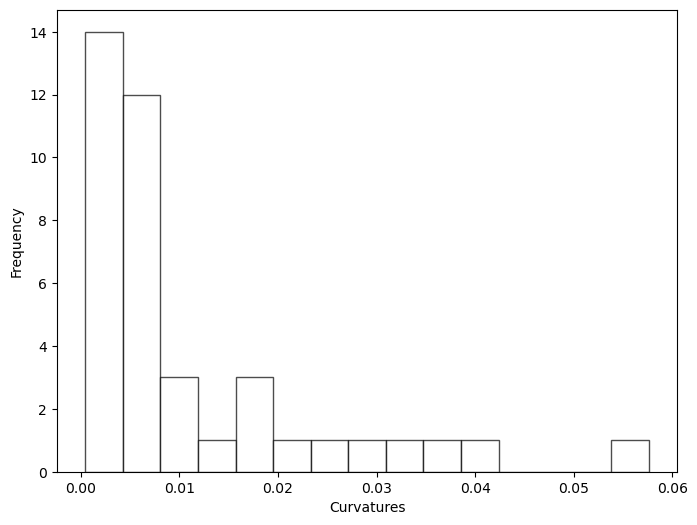

In [19]:
first_mesh = mesh_sequence[0]
first_frame = tracked_segmentations[0]
first_nodes = get_node_positions(first_mesh)
first_contour_points = get_contour_points(first_frame)
first_new_nodes = adjust_nodes(first_nodes, first_contour_points)
first_edges = get_edges(first_new_nodes, first_contour_points)
first_curvatures = get_curvatures(first_edges)

first_curvatures = np.concatenate(list(first_curvatures.values()))

# Plot histogram of curvatures
plt.figure(figsize=(8,6))
plt.hist(first_curvatures, bins=15, edgecolor='black', alpha=0.7, color='white')
plt.xlabel("Curvatures")
plt.ylabel("Frequency")
plt.show()

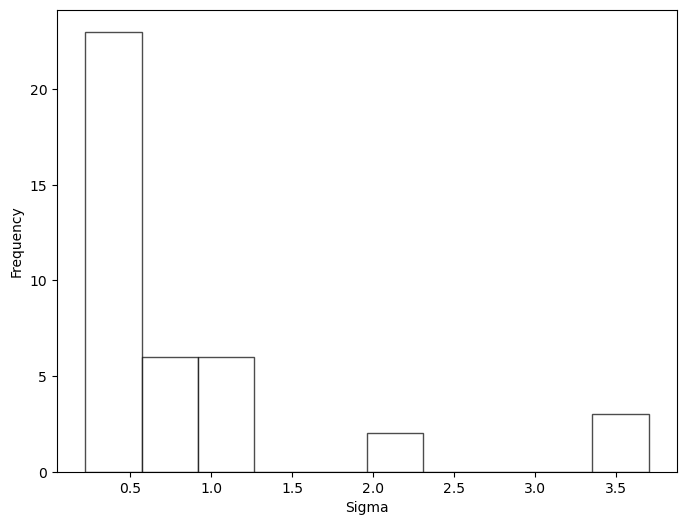

In [20]:
first_sigma = np.concatenate(list(get_circlefit(first_edges)[3].values()))

# Plot histogram of sigma values
plt.figure(figsize=(8,6))
plt.hist(first_sigma, edgecolor='black', alpha=0.7, color='white')
plt.xlabel("Sigma")
plt.ylabel("Frequency")
plt.show()

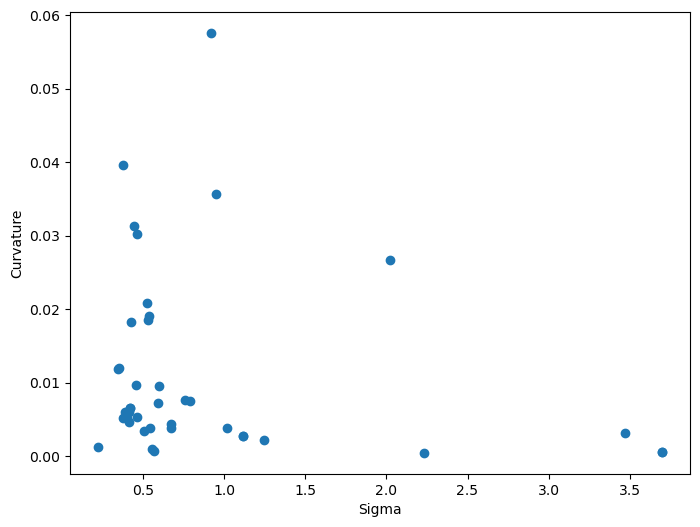

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(first_sigma, first_curvatures)
plt.xlabel("Sigma")
plt.ylabel("Curvature")
plt.show()

##### All frames

Use edges from every frame to create similar plots.

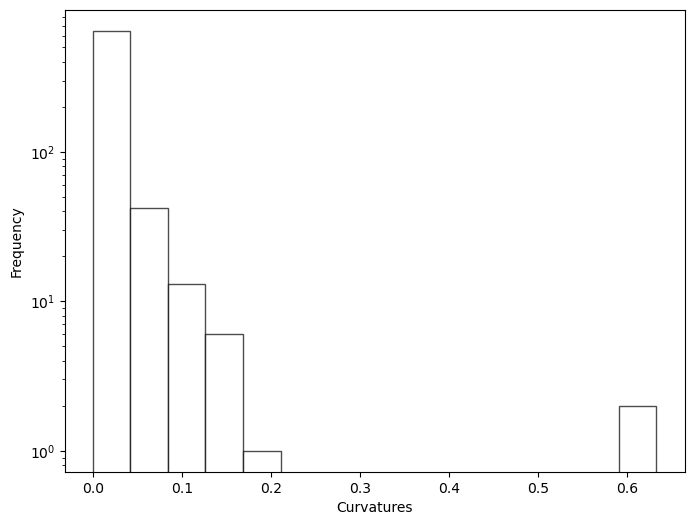

In [22]:
nframes = len(mesh_sequence)
ncurv = []
nsigma = []
for n in range(nframes):
    current_mesh = mesh_sequence[n]
    current_frame = tracked_segmentations[n] 
    
    inodes = get_node_positions(current_mesh)
    icontour_points = get_contour_points(current_frame)
    inew_nodes = adjust_nodes(inodes, icontour_points)
    iedges = get_edges(inew_nodes, icontour_points)
    icurv = get_curvatures(iedges)
    icurv = np.concatenate(list(icurv.values()))
    ncurv.append(icurv)
    isigma = np.concatenate(list(get_circlefit(iedges)[3].values()))
    nsigma.append(isigma)
ncurv = np.concatenate(ncurv)
nsigma = np.concatenate(nsigma)

# Plot histogram of curvatures
plt.figure(figsize=(8,6))
plt.hist(ncurv, bins=15, edgecolor='black', alpha=0.7, color='white')
plt.xlabel("Curvatures")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

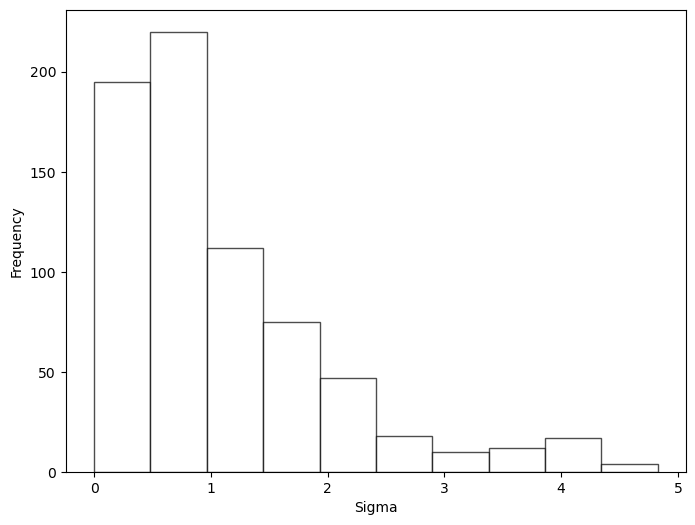

In [23]:
# Plot histogram of sigma values
plt.figure(figsize=(8,6))
plt.hist(nsigma, edgecolor='black', alpha=0.7, color='white')
plt.xlabel("Sigma")
plt.ylabel("Frequency")
plt.show()

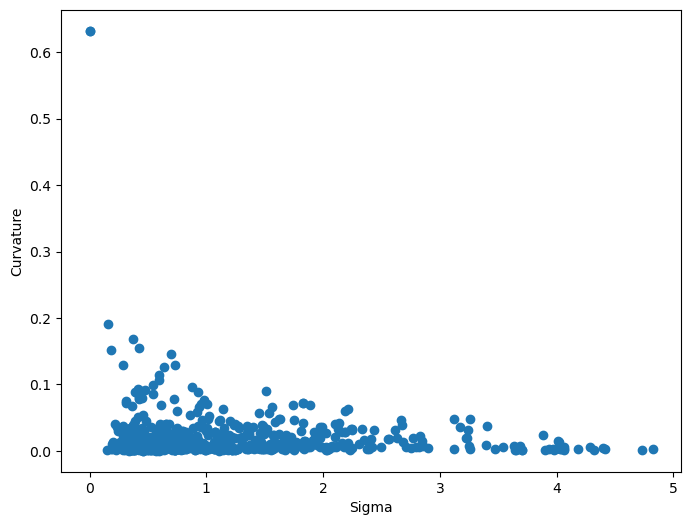

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(nsigma, ncurv)
plt.xlabel("Sigma")
plt.ylabel("Curvature")
plt.show()

#### Quality of fit

Need to find a standardised sigma value to compare the quality of the circle fit,
*i.e. standardise root mean square (RMS) values (sigma)*

* Try dividing RMS by arc length for each edge

##### Arc Length

In [25]:
def get_closest_point_on_circle(p, c, r):
    # Calculate the distance from the circle centre to the point
    d = get_distance(p, c)
    # If the point is on the circle, return the point itself
    if d == r:
        return p
    # Calculate direction of the vector from centre to the point
    di = (p - c) / d
    # Find closest point on the circle by scaling direction vector
    cp = c + r * di
    return cp

In [26]:
# Test closest point function
for edge in edges:
    print('Point:', edge[0]) 
    xc1, yc1, r1, sigma1 = cf.taubinSVD(edge)
    cp = get_closest_point_on_circle(edge[0], [xc1, yc1], r1)
    print('Closest point:', cp)
    print('Closest point is on circle:', np.isclose((cp[0]-xc1)**2+(cp[1]-yc1)**2, r1**2))

Point: [558 391]
Closest point: [556.41219891 391.01589546]
Closest point is on circle: True
Point: [548 329]
Closest point: [547.94939675 328.98045769]
Closest point is on circle: True
Point: [561 277]
Closest point: [560.60864947 275.86946273]
Closest point is on circle: True
Point: [605 246]
Closest point: [604.36093362 246.23968517]
Closest point is on circle: True
Point: [594 365]
Closest point: [594.60554625 365.3537643 ]
Closest point is on circle: True


In [27]:
def get_arc_length(edge, c, r):
    # Find arc endpoints (p1 and p3) and middle point (p2)
    p1 = get_closest_point_on_circle(edge[0], c, r)
    p2 = get_closest_point_on_circle(edge[(len(edge)-1) // 2], c, r)
    p3 = get_closest_point_on_circle(edge[-1], c, r)
    # Calculate the central angles
    # One half of chord is the side of a right angled triangle
    chord1 = get_distance(p1, p2)
    chord2 = get_distance(p2, p3)
    theta1 = 2 * np.arcsin(chord1 / (2 * r))
    theta2 = 2 * np.arcsin(chord2 / (2 * r))
    # Calculate arc length
    return (theta1 + theta2) * r

In [28]:
for edge in edges:
    xc1, yc1, r1, sigma1 = cf.taubinSVD(edge)
    arc1 = get_arc_length(edge, [xc1, yc1], r1)
    print('Sigma:', sigma1)
    print('New sigma:', sigma1/arc1)

Sigma: 0.5416754552389081
New sigma: 0.008629090539490132
Sigma: 0.45904942918276154
New sigma: 0.008563438482568561
Sigma: 0.5955672508973493
New sigma: 0.011004565744656674
Sigma: 0.7857171288826386
New sigma: 0.006412128267870945
Sigma: 0.5368529254876961
New sigma: 0.011666475696064781


##### Define function

In [29]:
def get_sigmas(edges):
    nsigmas = {}
    for cell_id in edges:
        edgesi = edges[cell_id]
        sigmas = []
        for edge in edgesi:
            if len(edge) > 2: # Don't include edges containing fewer than three points
                xc, yc, r, sigma = cf.taubinSVD(edge)
                arc = get_arc_length(edge, [xc,yc], r)
                new_sigma = sigma / arc
                sigmas.append(new_sigma)
        nsigmas[cell_id] = sigmas
    return nsigmas

##### Analyse quality of fit

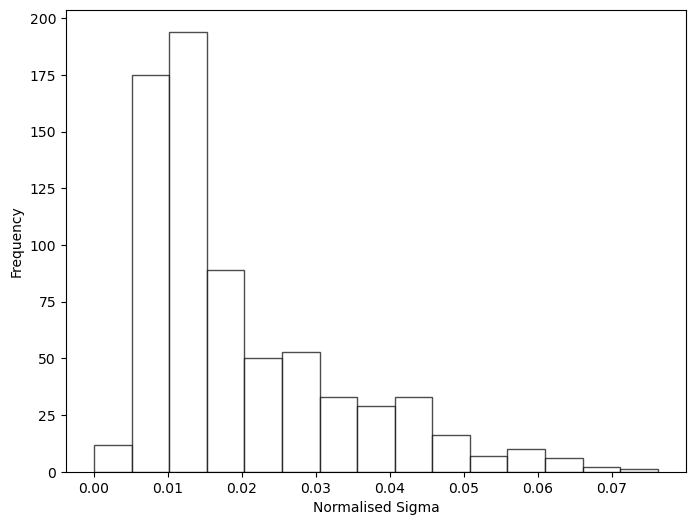

In [30]:
nframes = len(mesh_sequence)
nsigmas = []
for n in range(nframes):
    current_mesh = mesh_sequence[n]
    current_frame = tracked_segmentations[n] 
    
    inodes = get_node_positions(current_mesh)
    icontour_points = get_contour_points(current_frame)
    inew_nodes = adjust_nodes(inodes, icontour_points)
    iedges = get_edges(inew_nodes, icontour_points)
    isigmas = get_sigmas(iedges)
    isigmas = np.concatenate(list(isigmas.values()))
    nsigmas.append(isigmas)
nsigmas = np.concatenate(nsigmas)

# Plot histogram of curvatures
plt.figure(figsize=(8,6))
plt.hist(nsigmas, bins=15, edgecolor='black', alpha=0.7, color='white')
plt.xlabel("Normalised Sigma")
plt.ylabel("Frequency")
plt.show()

In [31]:
arcs = []
for edge in edges:
    n = len(edge)
    distances = np.zeros(n)
    for i in range(n-1):
        # Calculate Euclidean distance between consecutive points
        distances[i] = get_distance(edge[i],edge[i+1])
    # Sum up the distances to get the arc length
    arcs.append(np.sum(distances))
print('Arc lengths:')
print(arcs)
print('Old sigmas:')
print(sigmalm)
print('New sigmas:')
print(sigmalm/arcs)

Arc lengths:
[66.14213562373095, 57.970562748477136, 59.18376618407357, 131.35533905932738, 49.698484809834994]
Old sigmas:
[0.54167546 0.45904943 0.59556725 0.78569711 0.53683913]
New sigmas:
[0.00818957 0.00791866 0.01006302 0.00598146 0.01080192]


## Defining Lamellipodia

### Merging edges

Lamellipodia may span two or more edges so neighbouring edges must be merged if they form a single curved lamellipodia.

* Try combining neighbouring edges and fitting a circle - if the quality of fit is under a certain threshold, add the merged edged to a list of new edges

#### Test with specific cell

* Look at the circle fit for each combination of neighbour edge in a single cell

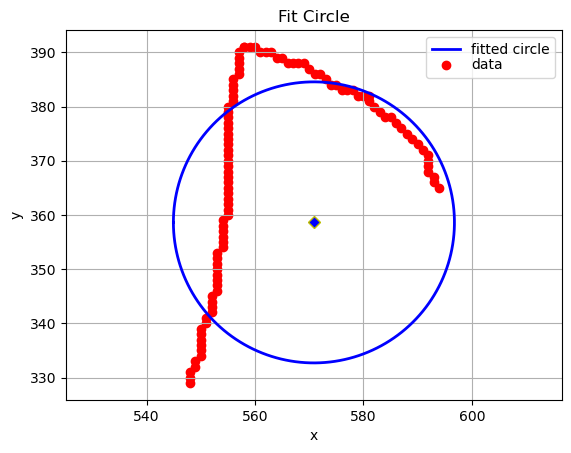

Curvature: 0.038564721730450585
Sigma: 0.056332709785994056


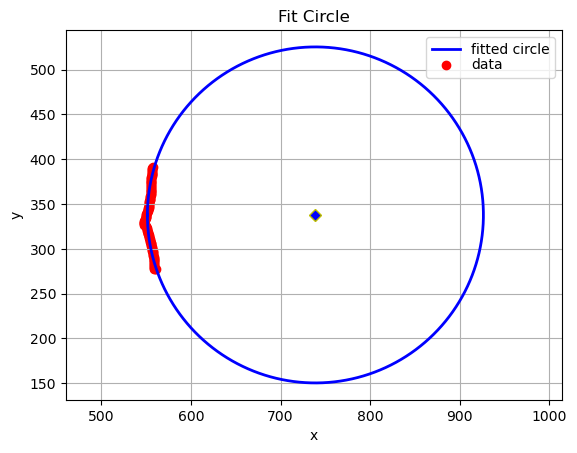

Curvature: 0.0053337398071772795
Sigma: 0.012521510949391787


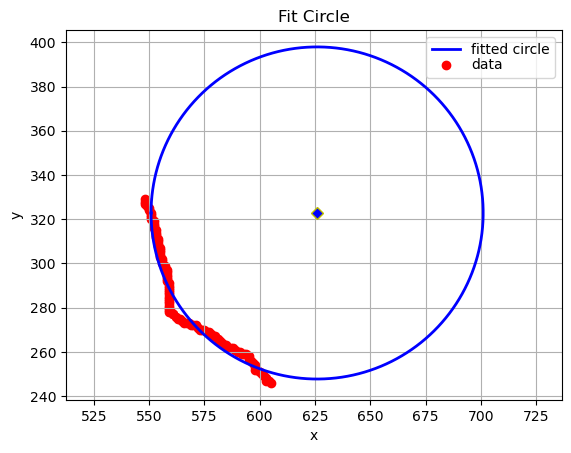

Curvature: 0.013320399634403986
Sigma: 0.02327581952871435


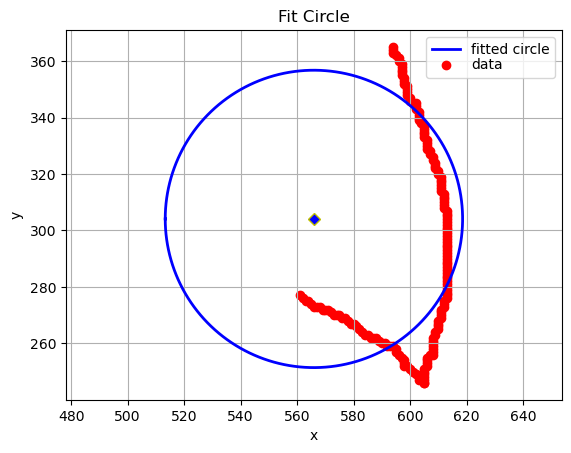

Curvature: 0.018989552692604997
Sigma: 0.06340237675847642


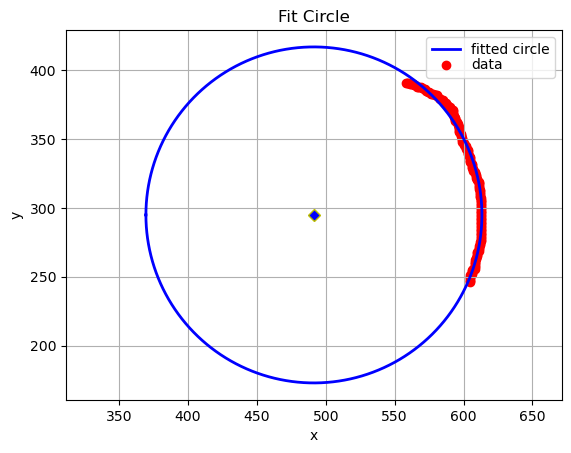

Curvature: 0.008199695247607804
Sigma: 0.009746472041805815


In [32]:
for i in range(nedges):
    xc1, yc1, r1, sigma1 = cf.taubinSVD(edges[i-1])
    xc2, yc2, r2, sigma2 = cf.taubinSVD(edges[i])
    combined_edge = np.concatenate((edges[i-1],edges[i]))
    
    xcc, ycc, rc, sigmac = cf.taubinSVD(combined_edge)
    cf.plot_data_circle(combined_edge, xcc, ycc, rc)
    
    arcc = get_arc_length(combined_edge, [xcc, ycc], rc)
    p = get_closest_point_on_circle(combined_edge[-1], [xcc, ycc], rc)
    print('Curvature:', 1 / rc)
    print('Sigma:', sigmac / arcc)

We see a high quality of fit between neighbouring edges that do not form lamellipodia.

Possible solutions:
* Find the vectors from the centre of the fitted circle that perpendicularly bisect the chords formed between the endpoints of each edge, for individual and combined edges. Compare the direction of the vector formed with the combined edge to that formed with the individual edges.
    * *Would not work for first circle fit in specified cell above*
* **Compare circle overlap of individual edge circle fits with combined edge circle fits.**

In [33]:
def get_circle_overlap(c1, r1, c2, r2):
    d = get_distance(np.array(c1), np.array(c2))
    
    # Check if circles don't overlap
    if d >= r1 + r2:
        return 0
    # Check if one circle is completely inside the other
    if d <= np.abs(r1 - r2):
        return min(np.pi * r1**2, np.pi * r2**2) # Return area of smaller circle
    
    # Else calculate overlapping area
    alpha = np.arccos((d**2 + r1**2 - r2**2) / (2 * d * r1))
    beta = np.arccos((d**2 + r2**2 - r1**2) / (2 * d * r2))
    overlap = r1**2 * alpha + r2**2 * beta - 0.5 * (r1**2 * np.sin(2 * alpha) + r2**2 * np.sin(2 * beta))
    
    # Normalise overlap by dividing by summed areas
    a1 = np.pi * r1**2
    a2 = np.pi * r2**2
    return overlap / (a1 + a2)

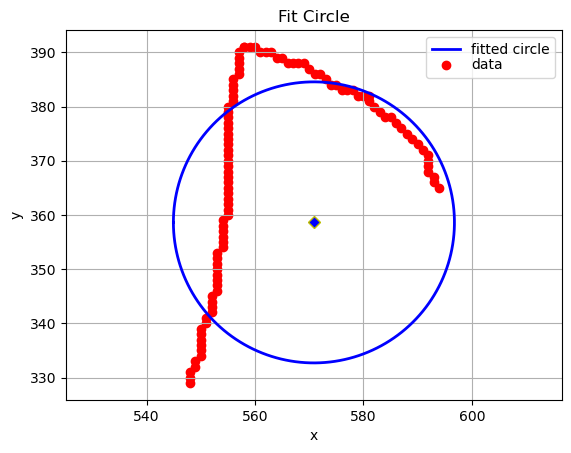

Overlap: 0.19122215839599405
Sigma: 0.056332709785994056


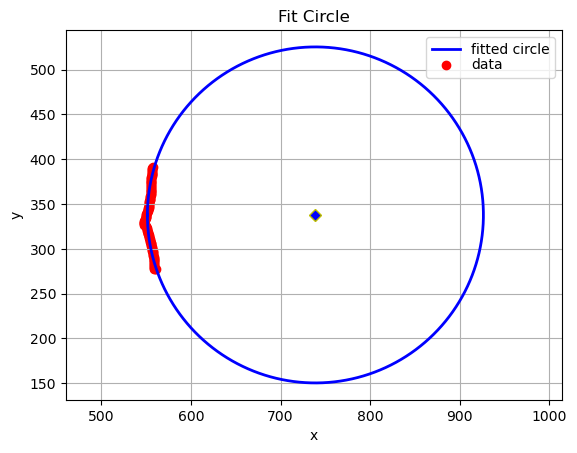

Overlap: 0.00024949381136882824
Sigma: 0.012521510949391787


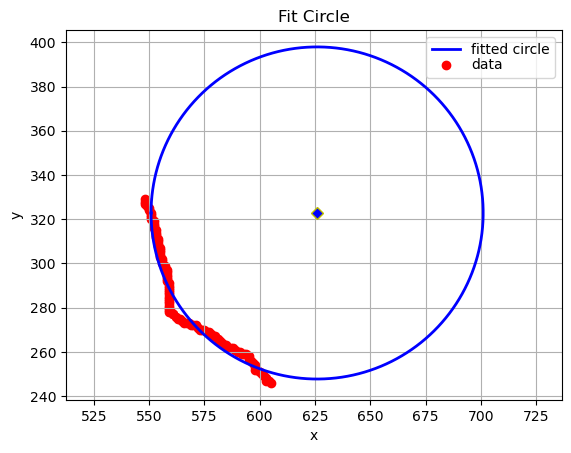

Overlap: 0.001684534999467746
Sigma: 0.02327581952871435


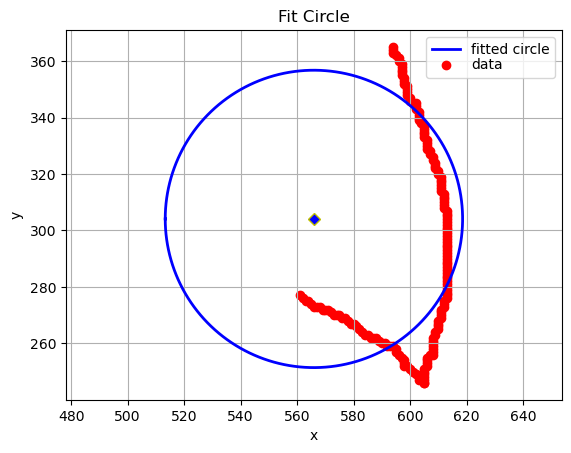

Overlap: 0.16145310048824768
Sigma: 0.06340237675847642


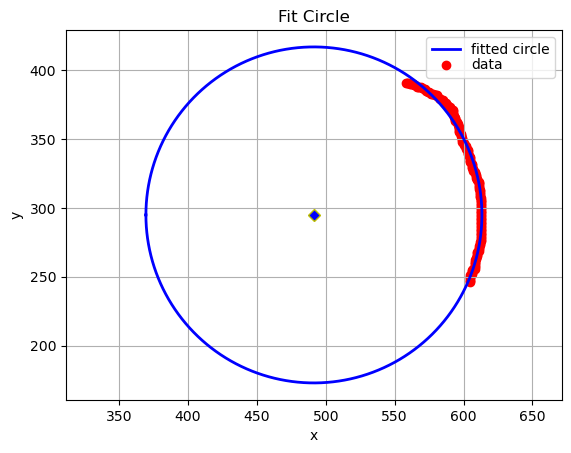

Overlap: 0.6132361022564333
Sigma: 0.009746472041805815


In [34]:
for i in range(nedges):
    xc1, yc1, r1, sigma1 = cf.taubinSVD(edges[i-1])
    xc2, yc2, r2, sigma2 = cf.taubinSVD(edges[i])
    
    combined_edge = np.concatenate((edges[i-1],edges[i]))
    xcc, ycc, rc, sigmac = cf.taubinSVD(combined_edge)
    cf.plot_data_circle(combined_edge, xcc, ycc, rc)
    
    overlap1 = get_circle_overlap([xcc, ycc], rc, [xc1, yc1], r1)
    overlap2 = get_circle_overlap([xcc, ycc], rc, [xc2, yc2], r2)
    total_overlap = overlap1 + overlap2
    print('Overlap:', total_overlap)
    
    arcc = get_arc_length(combined_edge, [xcc, ycc], rc)
    print('Sigma:', sigmac / arcc)

In [35]:
def is_merge(edge1, edge2):
    if len(edge1) < 3 or len(edge2) < 3:
        return False
    xc1, yc1, r1, sigma1 = cf.taubinSVD(edge1)
    xc2, yc2, r2, sigma2 = cf.taubinSVD(edge2)
    
    combined_edge = np.concatenate((edge1, edge2))
    xcc, ycc, rc, sigmac = cf.taubinSVD(combined_edge)
    
    overlap1 = get_circle_overlap([xcc, ycc], rc, [xc1, yc1], r1)
    overlap2 = get_circle_overlap([xcc, ycc], rc, [xc2, yc2], r2)
    total_overlap = overlap1 + overlap2
    
    if total_overlap < 0.4:
        return False
    
    arcc = get_arc_length(combined_edge, [xcc, ycc], rc)
    sigma = sigmac / arcc
    
    if sigma > 0.016:
        return False
    
    return True

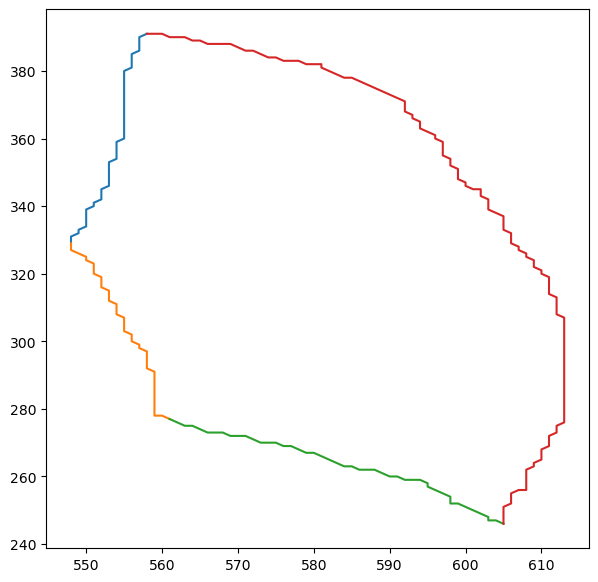

In [36]:
new_edges = []
for i in range(nedges + 1):
    if not new_edges:
        edge1 = edges[i-1]
        edge2 = edges[i]
        if is_merge(edge1, edge2):
            new_edges.append(np.concatenate((edge1, edge2)))
        else:
            new_edges.append(edge2)
    elif i == nedges:
        edge1 = new_edges[-1]
        edge2 = new_edges[0]
        if is_merge(edge1, edge2):
            new_edges[-1] = np.concatenate((edge1, edge2))
    else:
        edge1 = new_edges[-1]
        edge2 = edges[i]
        if is_merge(edge1, edge2):
            new_edges[-1] = np.concatenate((edge1, edge2))
        else:
            new_edges.append(edge2)

# Extract x and y coords of edges
new_edges_x = {}
new_edges_y = {}
for i, edge in enumerate(new_edges):
    new_edges_x[i] = [point[0] for point in edge]
    new_edges_y[i] = [point[1] for point in edge]
# Plot edges
fig = plt.figure(figsize=(7,7))
for i in range(len(new_edges)):
    plt.plot(new_edges_x[i],new_edges_y[i])
plt.show()

In [37]:
#### OLD VERSION #####
def get_merged_edges(edges):
    merged_edges = {}
    for cell_id in edges:
        edgesi = edges[cell_id]
        nedgesi = len(edgesi)
        new_edges = []
        for i in range(nedgesi + 1):
            if not new_edges:
                edge1 = edgesi[i-1]
                edge2 = edgesi[i]
                if is_merge(edge1, edge2):
                    new_edges.append(np.concatenate((edge1, edge2)))
                else:
                    new_edges.append(edge2)
            elif i == nedgesi:
                edge1 = new_edges[-1]
                edge2 = new_edges[0]
                if is_merge(edge1, edge2):
                    new_edges[-1] = np.concatenate((edge1, edge2))
            else:
                edge1 = new_edges[-1]
                edge2 = edgesi[i]
                if is_merge(edge1, edge2):
                    new_edges[-1] = np.concatenate((edge1, edge2))
                else:
                    new_edges.append(edge2)
        merged_edges[cell_id] = new_edges
    return merged_edges

In [38]:
#### CORRECTED ####
def get_merged_edges(edges):
    merged_edges = {}
    for cell_id in edges:
        edgesi = edges[cell_id]
        nedgesi = len(edgesi)
        new_edges = []
        for i in range(nedgesi):
            if not new_edges:
                edge1 = edgesi[i-1]
                edge2 = edgesi[i]
                if is_merge(edge1, edge2):
                    new_edges.append(np.concatenate((edge1, edge2)))
                    initial_merge = True
                else:
                    new_edges.append(edge2)
                    initial_merge = False
            elif i == nedgesi-1 and initial_merge:
                edge1 = new_edges[-1]
                edge2 = new_edges[0]
                if is_merge(edge1, edge2):
                    new_edges[-1] = np.concatenate((edge1, edge2))
            else:
                edge1 = new_edges[-1]
                edge2 = edgesi[i]
                if is_merge(edge1, edge2):
                    new_edges[-1] = np.concatenate((edge1, edge2))
                else:
                    new_edges.append(edge2)
        merged_edges[cell_id] = new_edges
    return merged_edges

### Qualifying Lamellipodia

To define an edge in a given cell as a lamellipodium we must qualify whether the curvature and quality of fit are within a certain threshold.

In [39]:
print('Curvature / Sigma:')
for edge in new_edges:
    xc, yc, r, sigma = cf.taubinSVD(edge)
    arc = get_arc_length(edge, [xc, yc], r)
    print(1 / r, '/', sigma / arc)

Curvature / Sigma:
0.003799903360548534 / 0.008629090539490132
0.005343160550897828 / 0.008563438482568561
0.009525820397250442 / 0.011004565744656674
0.008199695247607804 / 0.009746472041805815


In [40]:
def is_lamellipodia(edge):
    xc, yc, r, sigma = cf.taubinSVD(edge)
    curvature = 1 / r
    arc = get_arc_length(edge, [xc, yc], r)
    new_sigma = sigma / arc
    if (1 / r) > 0.005 and new_sigma < 0.02:
        return True
    return False

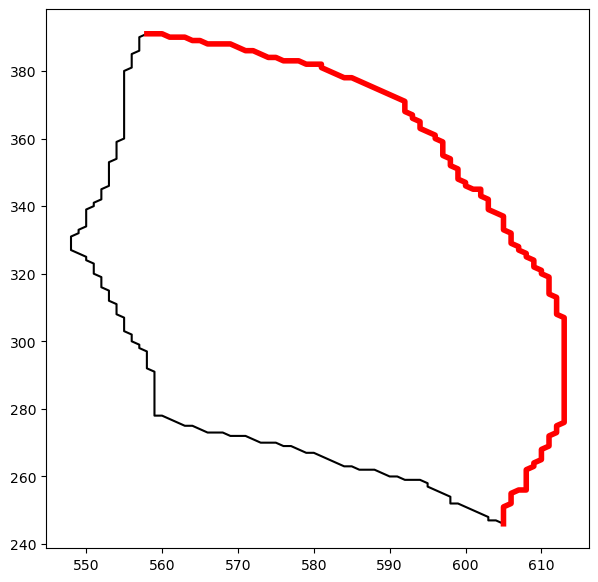

In [41]:
cell_edge = np.concatenate(new_edges)
xcc, ycc, rc, sigmac = cf.taubinSVD(cell_edge)
lamellipodia = []
for edge in new_edges:
    if is_lamellipodia(edge):
        xc1, yc1, r1, sigma1 = cf.taubinSVD(edge)
        overlap = get_circle_overlap([xc1, yc1], r1, [xcc, ycc], rc)
        if overlap > 0.1:
            lamellipodia.append(edge)

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
for i, lamel in enumerate(lamellipodia):
    lamel_x[i] = [point[0] for point in lamel]
    lamel_y[i] = [point[1] for point in lamel]
cell_x = []
cell_y = []
for point in cell_edge:
    cell_x.append(point[0])
    cell_y.append(point[1])

# Plot lamellipodia
fig = plt.figure(figsize=(7,7))
plt.plot(cell_x, cell_y, color='black')
for i in range(len(lamellipodia)):
    plt.plot(lamel_x[i], lamel_y[i], color='red', linewidth=4)
plt.show()

### Assigning lamellipodia

We must then determine whether that lamellipodium belongs to the given cell:

* Try fitting a circle to the given cell and compare overlap with the circle fitted to the lamellipodium
* Try using shapely to check if point is inside cell polygon

#### Overlap method

In [42]:
def get_lamellipodia(edges, curvature = 0.005, sigma = 0.02, overlap = 0.1):
    nlamel = {}
    for cell_id in edges:
        edgesi = edges[cell_id]
        
        cell_edge = np.concatenate(edgesi)
        xcc, ycc, rc, sigmac = cf.taubinSVD(cell_edge)
        
        lamel = []
        for edge in edgesi:
            xci, yci, ri, sigmai = cf.taubinSVD(edge)
            curvaturei = 1 / ri
            arci = get_arc_length(edge, [xci, yci], ri)
            new_sigmai = sigmai / arci
            if curvaturei > curvature and new_sigmai < sigma:
                overlapi = get_circle_overlap([xci, yci], ri, [xcc, ycc], rc)
                if overlapi > overlap:
                    lamel.append(edge)
        nlamel[cell_id] = lamel
    return nlamel

##### Analyse method

5
7
10
11
12
13
31


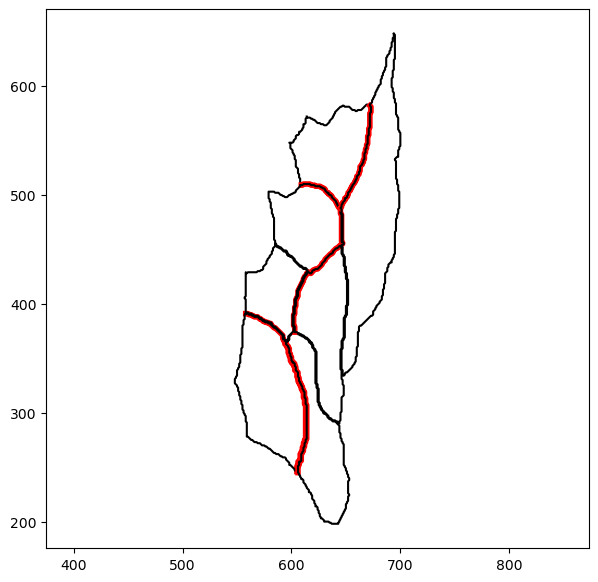

In [43]:
first_mesh = mesh_sequence[0]
first_frame = tracked_segmentations[0]

nodes1 = get_node_positions(first_mesh)
contour_points1 = get_contour_points(first_frame)
new_nodes1 = adjust_nodes(nodes1, contour_points1)
edges1 = get_edges(new_nodes1, contour_points1)
new_edges1 = get_merged_edges(edges1)
lamellipodia1 = get_lamellipodia(new_edges1)

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia1:
    lameli = lamellipodia1[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi
    
    cell_edgei = np.concatenate(new_edges1[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edgei]
    cell_y[cell_id] = [point[1] for point in cell_edgei]

# Plot lamellipodia
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
for cell_id in cell_x:
    print(cell_id)
    for i in range(len(lamel_x[cell_id])):
        plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.show()

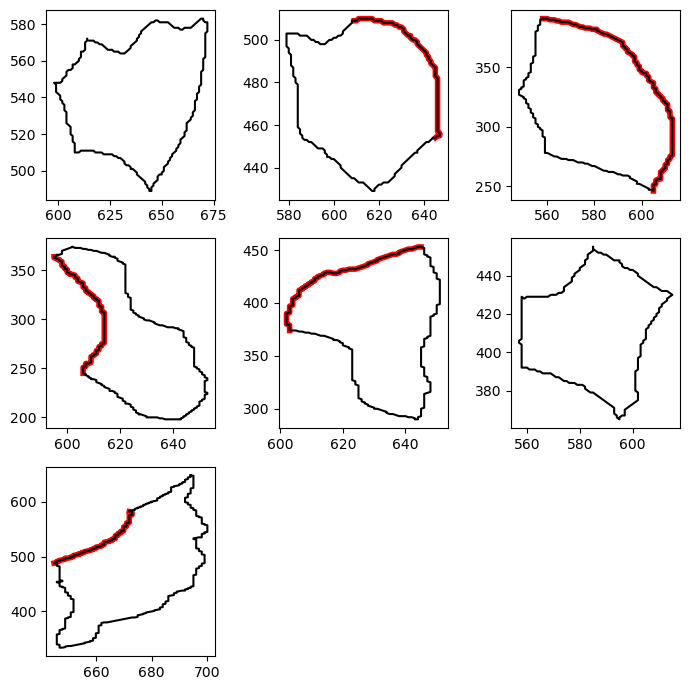

In [44]:
cells = list(lamellipodia1.keys())
# Plot lamellipodia
fig, ax = plt.subplots(3, 3, figsize=(7,7))
for j, cell_id in enumerate(cells):
    row = j // 3
    col = j % 3
    for i in range(len(lamel_x[cell_id])):
        ax[row, col].plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    ax[row, col].plot(cell_x[cell_id], cell_y[cell_id], color='black')
ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

*Some lamellipodia assigned to incorrect cells*

--> Try polygon method

#### Polygon method

##### Test with specific cell

Try different cell polygons:
* Nodes and edge midpoints
* Nodes and multiple points on edge
* All points

In [45]:
def get_midpoint(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2
    return (mid_x, mid_y)

In [46]:
# Create cell polygon (node and edge midpoints)
cell_points = []
for edge in new_edges:
    cell_points.append(edge[0])
    cell_points.append(edge[len(edge)//2])
    
cell_poly = Polygon(cell_points)

# Test if cell contains lamellipodia midpoint
for edge in new_edges:
    mid = get_midpoint(edge[0], edge[-1])
    point = Point(mid)
    print(cell_poly.contains(point))

False
False
False
True


##### Define function

In [47]:
def get_cell_polygon(edges):
    cell_points = []
    for edge in edges:
        cell_points.append(edge[0])
        cell_points.append(edge[len(edge)//2])
    return Polygon(cell_points)

def get_lamellipodia(edges, curvature = 0.005, sigma = 0.02):
    nlamel = {}
    for cell_id in edges:
        edgesi = edges[cell_id]
        cell_polyi = get_cell_polygon(edgesi)
        
        lamel = []
        for edge in edgesi:
            xci, yci, ri, sigmai = cf.taubinSVD(edge)
            curvaturei = 1 / ri
            arci = get_arc_length(edge, [xci, yci], ri)
            new_sigmai = sigmai / arci
            if curvaturei > curvature and new_sigmai < sigma:
                midi = get_midpoint(edge[0], edge[-1])
                pointi = Point(midi)
                if cell_polyi.contains(pointi):
                    lamel.append(edge)
        nlamel[cell_id] = lamel
    return nlamel

##### Analyse method

5
7
10
11
12
13
31


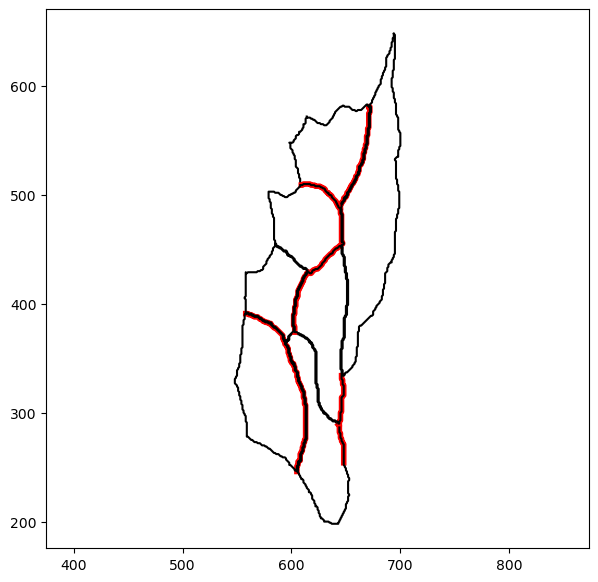

In [48]:
first_mesh = mesh_sequence[0]
first_frame = tracked_segmentations[0]

nodes1 = get_node_positions(first_mesh)
contour_points1 = get_contour_points(first_frame)
new_nodes1 = adjust_nodes(nodes1, contour_points1)
edges1 = get_edges(new_nodes1, contour_points1)
new_edges1 = get_merged_edges(edges1)
lamellipodia1 = get_lamellipodia(new_edges1)

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia1:
    lameli = lamellipodia1[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi
    
    cell_edgei = np.concatenate(new_edges1[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edgei]
    cell_y[cell_id] = [point[1] for point in cell_edgei]

# Plot lamellipodia
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
for cell_id in cell_x:
    print(cell_id)
    for i in range(len(lamel_x[cell_id])):
        plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.show()

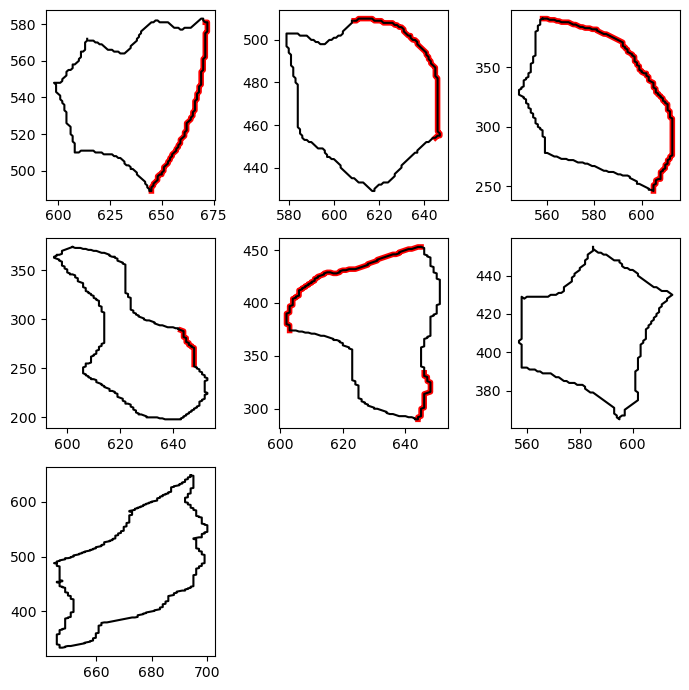

In [49]:
cells = list(lamellipodia1.keys())
# Plot lamellipodia
fig, ax = plt.subplots(3, 3, figsize=(7,7))
for j, cell_id in enumerate(cells):
    row = j // 3
    col = j % 3
    for i in range(len(lamel_x[cell_id])):
        ax[row, col].plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    ax[row, col].plot(cell_x[cell_id], cell_y[cell_id], color='black')
ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

##### Analysis of cells 11 and 12

No. of edges in cell 11: 6


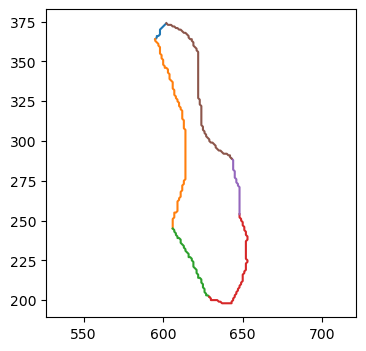

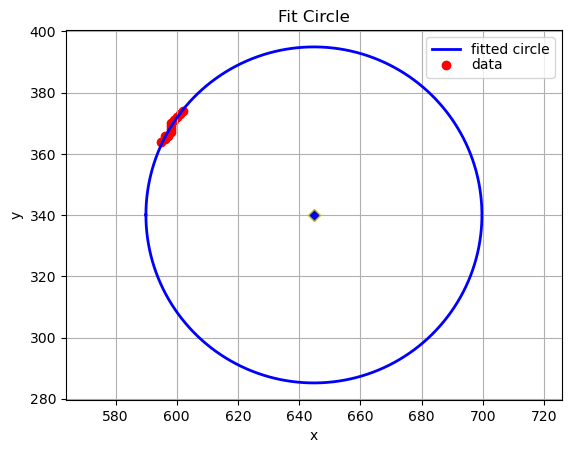

Curvature: 0.01821960012252805
Sigma: 0.034925883181129595


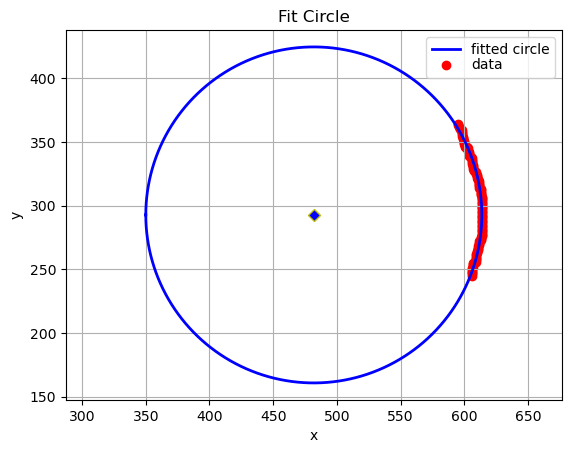

Curvature: 0.00758054280906394
Sigma: 0.006193028053988666


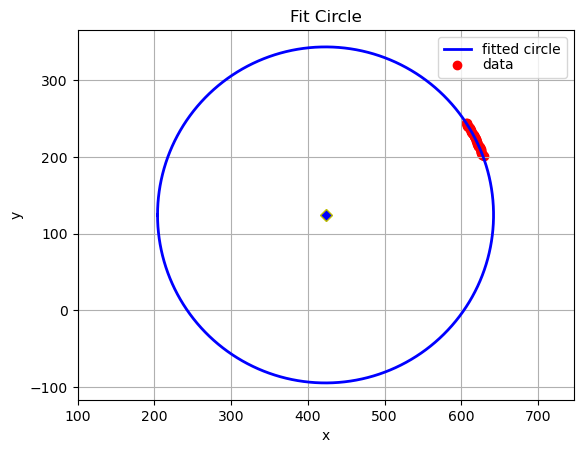

Curvature: 0.004566121113152137
Sigma: 0.008429080437770953


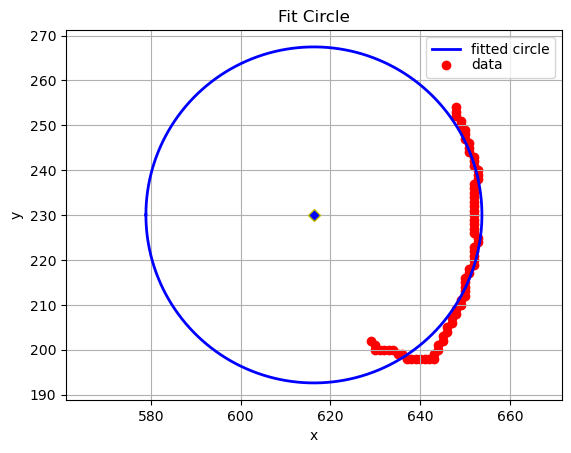

Curvature: 0.02671582962094271
Sigma: 0.03013742643227629


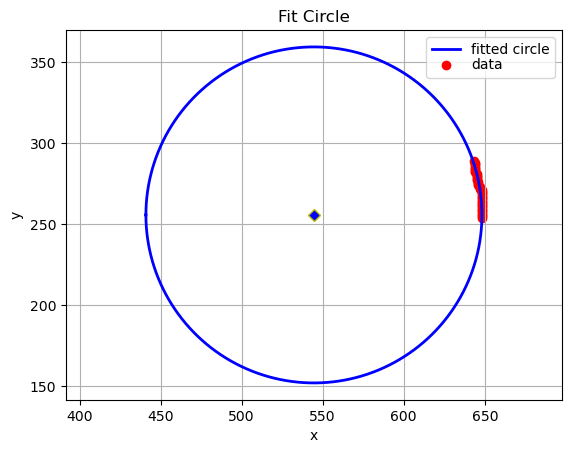

Curvature: 0.009650210135705155
Sigma: 0.012861148776408319


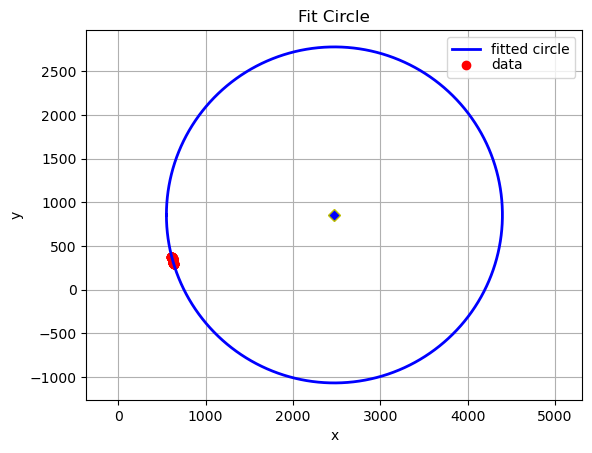

Curvature: 0.0005197270818637031
Sigma: 0.03981890793571958
No. of edges in cell 12: 4


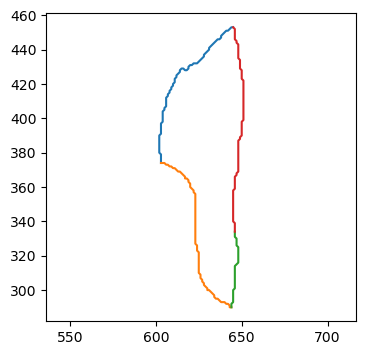

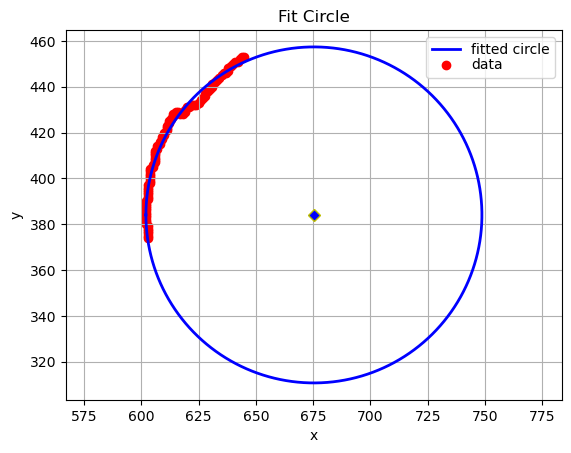

Curvature: 0.013638623002044228
Sigma: 0.013717905545776917


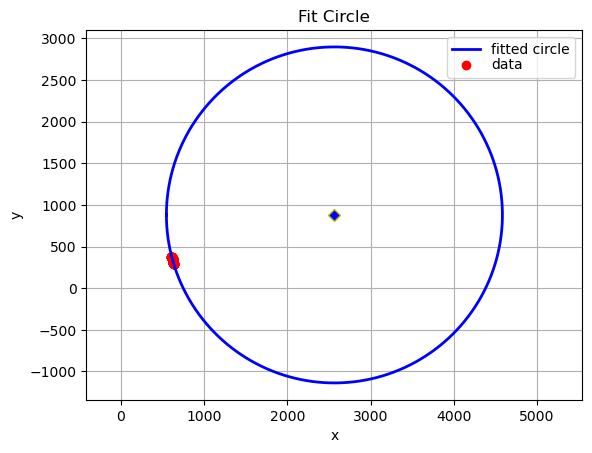

Curvature: 0.0004957137057539042
Sigma: 0.040233165063823996


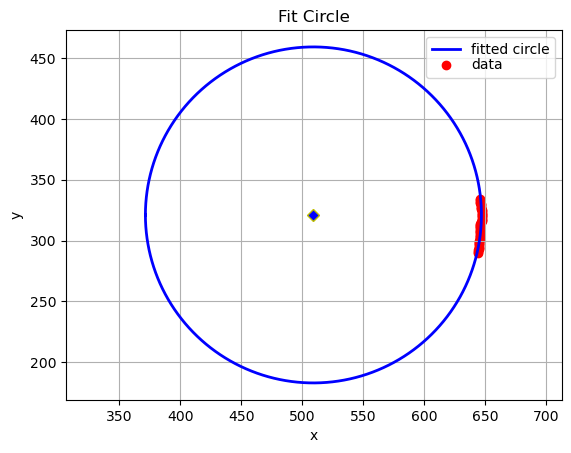

Curvature: 0.007248562434004096
Sigma: 0.013408045026700068


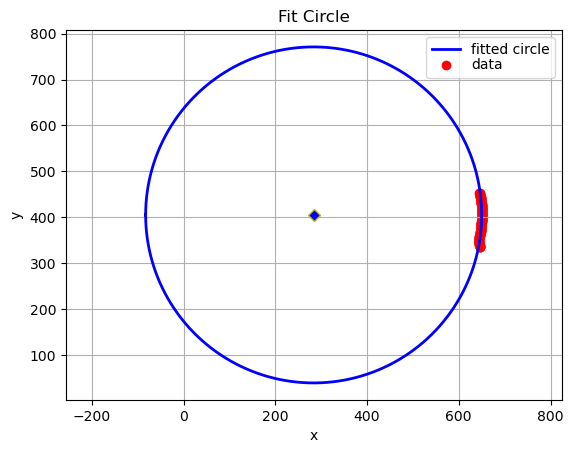

Curvature: 0.002729704881511364
Sigma: 0.009352825567390605


In [50]:
error_cells = [11,12]
for cell_id in error_cells:
    new_edgesi = new_edges1[cell_id]
    print(f"No. of edges in cell {cell_id}: {len(new_edgesi)}")
    
    # Extract x and y coords of edges
    new_edges_x = {}
    new_edges_y = {}
    for i, edge in enumerate(new_edgesi):
        new_edges_x[i] = [point[0] for point in edge]
        new_edges_y[i] = [point[1] for point in edge]
    # Plot edges
    fig = plt.figure(figsize=(4,4))
    for i in range(len(new_edgesi)):
        plt.plot(new_edges_x[i],new_edges_y[i])
    plt.axis('equal')
    plt.show()
    
    # Print curvature analysis values
    for edge in new_edgesi:
        xci, yci, ri, sigmai = cf.taubinSVD(edge)
        cf.plot_data_circle(edge, xci, yci, ri)
        curvaturei = 1 / ri
        arci = get_arc_length(edge, [xci, yci], ri)
        new_sigmai = sigmai / arci
        print("Curvature:", curvaturei)
        print("Sigma:", new_sigmai)

### Qualifying Lamellipodia cont.

Need to add criteria for the proportion of cell outline that lamellipodia covers.

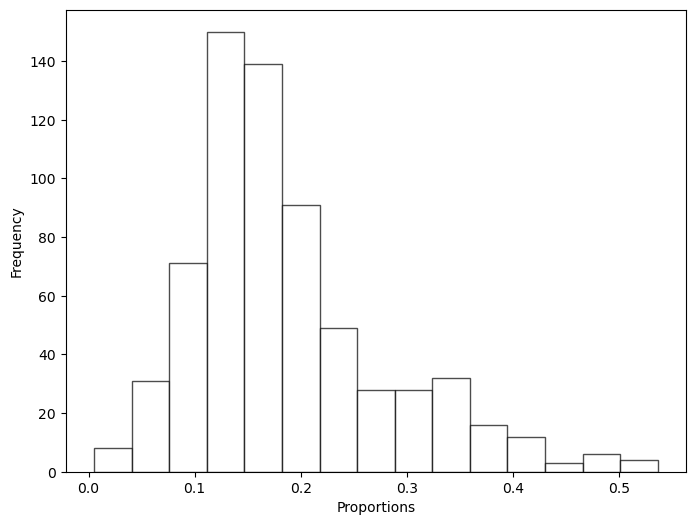

In [55]:
nframes = len(mesh_sequence)
nproportions = []
for n in range(nframes):
    current_mesh = mesh_sequence[n]
    current_frame = tracked_segmentations[n] 
    
    inodes = get_node_positions(current_mesh)
    icontour_points = get_contour_points(current_frame)
    inew_nodes = adjust_nodes(inodes, icontour_points)
    iedges = get_edges(inew_nodes, icontour_points)
    inew_edges = get_merged_edges(iedges)
    for cell_id in inew_edges:
        edgesi = inew_edges[cell_id]
        cell_outline = np.concatenate(edgesi)
        for edge in edgesi:
            nproportions.append(len(edge)/len(cell_outline))

# Plot histogram of edge proportions
plt.figure(figsize=(8,6))
plt.hist(nproportions, bins=15, edgecolor='black', alpha=0.7, color='white')
plt.xlabel("Proportions")
plt.ylabel("Frequency")
plt.show()

In [95]:
def get_lamellipodia(edges, curvature = 0.005, sigma = 0.02, proportion = 0.2, getstats = False):
    nlamel = {}
    nstats = {}
    for cell_id in edges:
        edgesi = edges[cell_id]
        cell_outline = np.concatenate(edgesi)
        cell_polyi = get_cell_polygon(edgesi)
        edgesi = [edge for edge in edgesi if len(edge) > 3]
        
        lamel = []
        stats = {}
        for edge in edgesi:
            xci, yci, ri, sigmai = cf.taubinSVD(edge)
            curvaturei = 1 / ri
            arci = get_arc_length(edge, [xci, yci], ri)
            new_sigmai = sigmai / arci
            proportioni = len(edge)/len(cell_outline)
            if curvaturei > curvature and new_sigmai < sigma and proportioni > proportion:
                midi = get_midpoint(edge[0], edge[-1])
                pointi = Point(midi)
                if cell_polyi.contains(pointi):
                    lamel.append(edge)
                    if stats:
                        stats['curv'].append(curvaturei)
                        stats['sigma'].append(new_sigmai)
                        stats['prop'].append(proportioni)
                    else:
                        stats['curv'] = [curvaturei]
                        stats['sigma'] = [new_sigmai]
                        stats['prop'] = [proportioni]
        if lamel:
            nlamel[cell_id] = lamel
            nstats[cell_id] = stats
    if getstats:
        return nlamel, nstats
    return nlamel

5
7
10
11
12
13
31


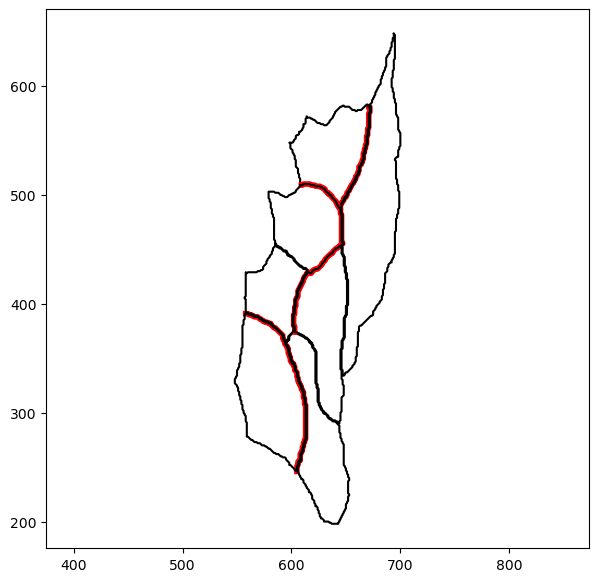

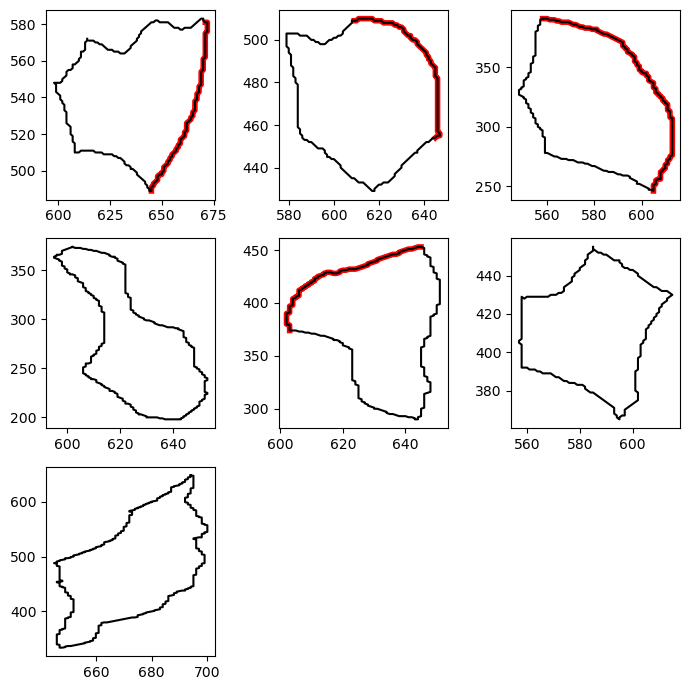

In [80]:
first_mesh = mesh_sequence[0]
first_frame = tracked_segmentations[0]

nodes1 = get_node_positions(first_mesh)
contour_points1 = get_contour_points(first_frame)
new_nodes1 = adjust_nodes(nodes1, contour_points1)
edges1 = get_edges(new_nodes1, contour_points1)
new_edges1 = get_merged_edges(edges1)
lamellipodia1 = get_lamellipodia(new_edges1)

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia1:
    lameli = lamellipodia1[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi
    
    cell_edgei = np.concatenate(new_edges1[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edgei]
    cell_y[cell_id] = [point[1] for point in cell_edgei]

# Plot lamellipodia
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
for cell_id in cell_x:
    print(cell_id)
    for i in range(len(lamel_x[cell_id])):
        plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.show()

cells = list(lamellipodia1.keys())
# Plot lamellipodia
fig, ax = plt.subplots(3, 3, figsize=(7,7))
for j, cell_id in enumerate(cells):
    row = j // 3
    col = j % 3
    for i in range(len(lamel_x[cell_id])):
        ax[row, col].plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    ax[row, col].plot(cell_x[cell_id], cell_y[cell_id], color='black')
ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

5
7
10
11
12
13
31


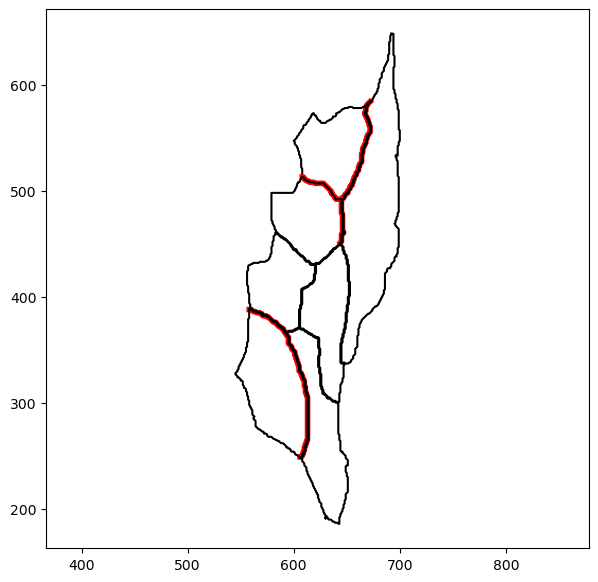

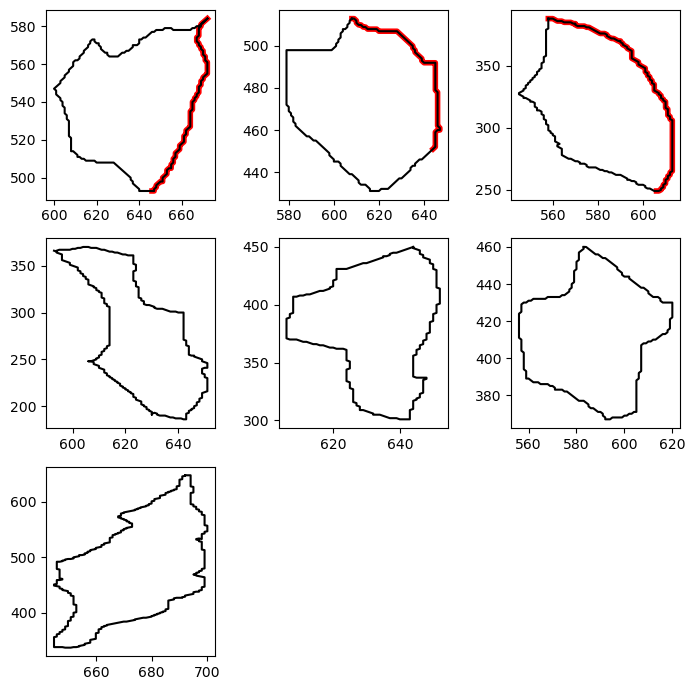

In [67]:
first_mesh = mesh_sequence[1]
first_frame = tracked_segmentations[1]

nodes1 = get_node_positions(first_mesh)
contour_points1 = get_contour_points(first_frame)
new_nodes1 = adjust_nodes(nodes1, contour_points1)
edges1 = get_edges(new_nodes1, contour_points1)
new_edges1 = get_merged_edges(edges1)
lamellipodia1 = get_lamellipodia(new_edges1)

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia1:
    lameli = lamellipodia1[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi
    
    cell_edgei = np.concatenate(new_edges1[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edgei]
    cell_y[cell_id] = [point[1] for point in cell_edgei]

# Plot lamellipodia
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
for cell_id in cell_x:
    print(cell_id)
    for i in range(len(lamel_x[cell_id])):
        plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.show()

cells = list(lamellipodia1.keys())
# Plot lamellipodia
fig, ax = plt.subplots(3, 3, figsize=(7,7))
for j, cell_id in enumerate(cells):
    row = j // 3
    col = j % 3
    for i in range(len(lamel_x[cell_id])):
        ax[row, col].plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    ax[row, col].plot(cell_x[cell_id], cell_y[cell_id], color='black')
ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

5
7
10
11
12
13
31


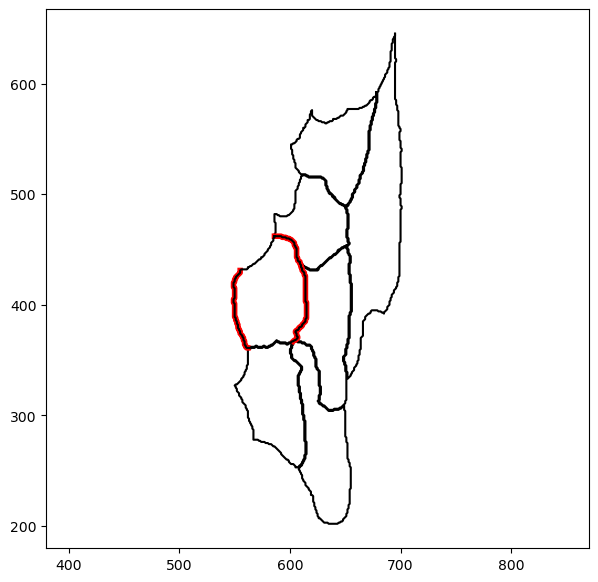

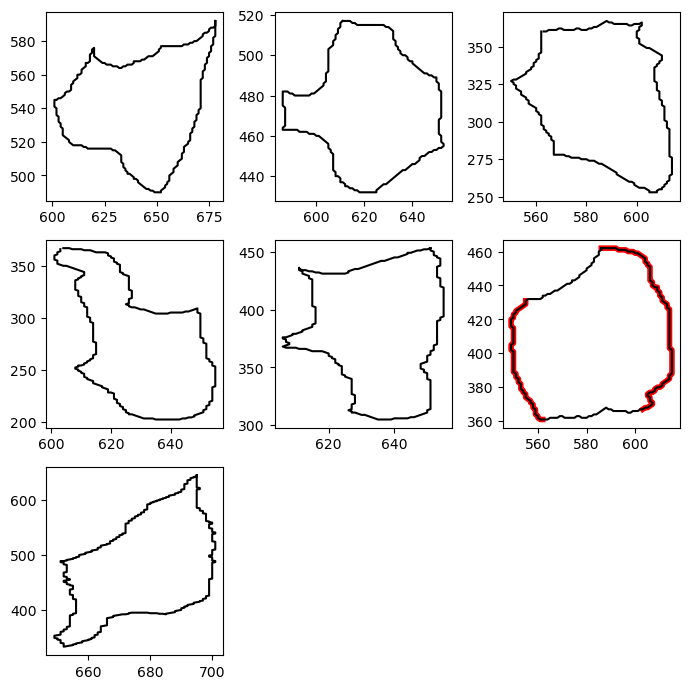

In [68]:
first_mesh = mesh_sequence[7]
first_frame = tracked_segmentations[7]

nodes1 = get_node_positions(first_mesh)
contour_points1 = get_contour_points(first_frame)
new_nodes1 = adjust_nodes(nodes1, contour_points1)
edges1 = get_edges(new_nodes1, contour_points1)
new_edges1 = get_merged_edges(edges1)
lamellipodia1 = get_lamellipodia(new_edges1)

# Extract x and y coords of lamellipodia
lamel_x = {}
lamel_y = {}
cell_x = {}
cell_y = {}
for cell_id in lamellipodia1:
    lameli = lamellipodia1[cell_id]
    lamel_xi = []
    lamel_yi = []
    for lamel in lameli:
        lamel_xi.append([point[0] for point in lamel])
        lamel_yi.append([point[1] for point in lamel])
    lamel_x[cell_id] = lamel_xi
    lamel_y[cell_id] = lamel_yi
    
    cell_edgei = np.concatenate(new_edges1[cell_id])
    cell_x[cell_id] = [point[0] for point in cell_edgei]
    cell_y[cell_id] = [point[1] for point in cell_edgei]

# Plot lamellipodia
fig = plt.figure(figsize=(7,7))
plt.axis('equal')
for cell_id in cell_x:
    print(cell_id)
    for i in range(len(lamel_x[cell_id])):
        plt.plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    plt.plot(cell_x[cell_id], cell_y[cell_id], color='black')
plt.show()

cells = list(lamellipodia1.keys())
# Plot lamellipodia
fig, ax = plt.subplots(3, 3, figsize=(7,7))
for j, cell_id in enumerate(cells):
    row = j // 3
    col = j % 3
    for i in range(len(lamel_x[cell_id])):
        ax[row, col].plot(lamel_x[cell_id][i], lamel_y[cell_id][i], color='red', linewidth=4)
    ax[row, col].plot(cell_x[cell_id], cell_y[cell_id], color='black')
ax[2, 1].axis('off')
ax[2, 2].axis('off')
plt.tight_layout()
plt.show()

## Analysing Lamellipodia

- Analyse distribution of curvature, quality of fit, and length
- Analyse direction of movement

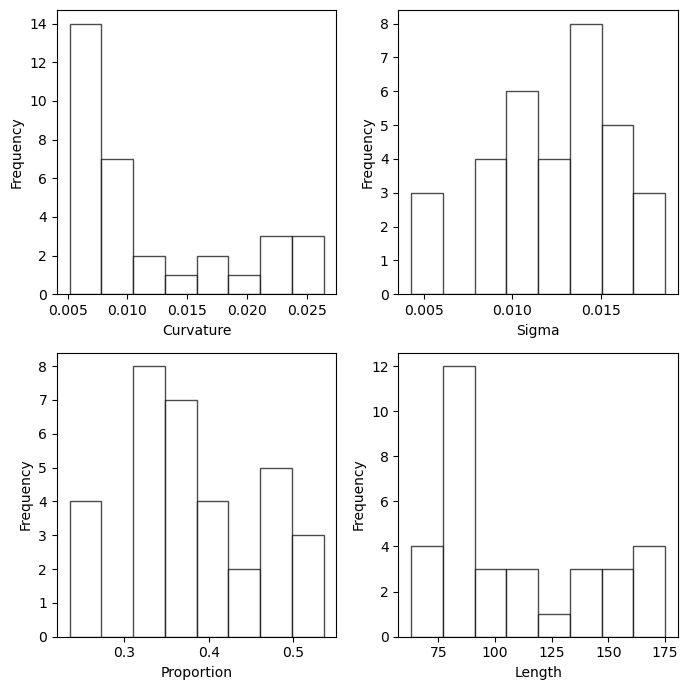

In [105]:
nframes = len(mesh_sequence)
ncurv = []
nsigma = []
nprop = []
nlamlen = []
for n in range(nframes):
    current_mesh = mesh_sequence[n]
    current_frame = tracked_segmentations[n] 
    
    inodes = get_node_positions(current_mesh)
    icontour_points = get_contour_points(current_frame)
    inew_nodes = adjust_nodes(inodes, icontour_points)
    iedges = get_edges(inew_nodes, icontour_points)
    inew_edges = get_merged_edges(iedges)
    ilamellipodia, istats = get_lamellipodia(inew_edges, getstats = True)
    for cell_id in ilamellipodia:
        ncurv.extend(istats[cell_id]['curv'])
        nsigma.extend(istats[cell_id]['sigma'])
        nprop.extend(istats[cell_id]['prop'])
        for lamel in ilamellipodia[cell_id]:
            nlamlen.append(len(lamel))

# Plot histogram of edge proportions
fig, ax = plt.subplots(2, 2, figsize=(7,7))
ax[0,0].hist(ncurv, bins=8, edgecolor='black', alpha=0.7, color='white')
ax[0,0].set_xlabel("Curvature")
ax[0,0].set_ylabel("Frequency")
ax[0,1].hist(nsigma, bins=8, edgecolor='black', alpha=0.7, color='white')
ax[0,1].set_xlabel("Sigma")
ax[0,1].set_ylabel("Frequency")
ax[1,0].hist(nprop, bins=8, edgecolor='black', alpha=0.7, color='white')
ax[1,0].set_xlabel("Proportion")
ax[1,0].set_ylabel("Frequency")
ax[1,1].hist(nlamlen, bins=8, edgecolor='black', alpha=0.7, color='white')
ax[1,1].set_xlabel("Length")
ax[1,1].set_ylabel("Frequency")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Next Steps:

- Criteria for edges that could belong to lamellipodia and test with visualisation for a set of frames

## Log:

**05/02/2024**

- Defined function to choose lamellipodia `get_lamellipodia()`
- Mixed success in first frame
    - Some lamellipodia correctly identified
    - Some lamellipodia not identified - *need to adjust criteria*
    - Some lamellipodia assigned to wrong cell - *may need to find alternative method for assigning lamellipodia*

**07/02/24**

- Define lamellipodia based on whether they span more than a certain percentage of the perimeter?
- Use Shapely package to define whether lamellipodia belongs to cell
- Migratory cell should only have one lamellipodia - constricting have two for example

**21/02/24**

- Using defined lamellipodia
    - Find direction of movement
    - Distribution of curvatures
    - Distribution of length
    - Correlation between speed and curvature (need tracked segmentations)
- Define whether migrating or constricting based on 1 or more lamellipodia, respectively
- Take stills of thick veins and segment and look at phenotype
- Streamline code
- Git commands